<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H3/Assignment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>
  <img alt="Colaboratory logo" width="150" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/1-polito.png" style="float: left; margin-right: 20px; margin-bottom: 10px;">
</p>    
<h1>
<h2><strong> Homework 3 - Network Dynamics and Learning </strong></h2>
<h3>Corso di Laurea Magistrale in DATA SCIENCE AND ENGINEERING</h3>


|Student| Email|
|:--:|:--:|
|Alejandra Solarte Uscategui| s321944@studenti.polito.it|
|Alejandro Mesa Gomez | s306638@studenti.polito.it|
|Anderson Estiver Alvarez Giraldo|  s310468@studenti.polito.it|
|Juliana Cortes Mendivil| s314545@studenti.polito.it|
|Mateo Rivera Monsalve|s320923@studenti.polito.it|


## Individual contributions

|Exercise|Student |
|:--:|:--:|
|2| Alejandra Solarte|
|1.3| Alejandro Mesa|
|| Anderson Alvarez|
|1.2| Juliana Cortes|
|1.1| Mateo Rivera|


# 1. Influenza H1N1 2009 Pandemic in Sweden
During the fall of 2009 there was a large pandemic of the H1N1-virus, commonly known as the swine-flu. During this pandemic it is estimated that about 1.5 million people in Sweden were infected. As an attempt to stop the pandemic and reduce excess mortality the government issued a vaccination program beginning in week 40 of 2009. During the weeks that followed they vaccinated more than 60% of the Swedish population.

In this homework, you will simulate the pandemic with the goal of learning the network-structure characteristics and disease-dynamics parameters of the pandemic in Sweden 2009. This task will be divided into 4 parts where the focus of each part is to:
1. Get started and learn how to:

    a. Simulate a pandemic on a known graph

    b. Generate a random graph
2. Simulate the disease propagation on a random graph without vaccination
3. Simulate disease propagation on a random graph with vaccination
4. Estimate the network-structure characteristics and disease-dynamics parameters for the pandemic in Sweden during the fall of 2009

All numbers regarding the H1N1 pandemic in Sweden during the fall of 2009 have been taken from the a report by the Swedish Civil Contingencies Agency (Myndigheten for samhallsskydd och beredskap, MSB) and the Swedish Institute for Communicable Disease Control (Smittskyddsinstitutet, SMI).

## 1.1 Preliminary parts
As a warm-up exercise we will start off by doing two preliminary parts. The first one will involve simulating an epidemic on a given graph, while the second part will be to generate a random graph with preferential attachment.

### 1.1.1 Epidemic on a known graph
In this part you will simulate an epidemic on a symmetric k-regular undirected graph with node set $V=\left\{1,2,...,n\right\}$ where every node is directly connected to the $k=6$ nodes whose index is closest to their own modulo $n$. See Figure 1 for an example with 8 nodes. The graph that you will simulate the epidemic on will however contain $n=500$ nodes.
<figure>
    <img width="256" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H3/sources/F1.png"/>
    <figcaption>Figure 1: Symmetric $k$-regular graph.</figcaption>
</figure>
The disease propagation model that you will use to simulate the epidemic is a discrete-time simplified version of the SIR epidemic model. At any time $t=0,1,...$ nodes are in state $X_{i}\left(t\right) \in\left\{S,I,R \right\}$, where $S$ is susceptible, $I$ is infected and $R$ is recovered. Let $\beta \in \left[0,1\right]$ be the probability that the infection is spread from an infected individual to a susceptible one (given that they are connected by a link) during one time step. Assuming that a susceptible node $i$ has $m$ infected neighbors, this means that the probability that individual $i$ does not get infected by any of the neighbors during one time step is $\left(1-\beta \right)^{m}$. Thus, the probability that individual $i$ becomes infected by any of its neighbors is $1-\left(1-\beta \right)^{m}$. Furthermore, let $\rho \in \left[0,1\right]$ be the probability that an infected individual will recover during one time step. The epidemic is driven by the following transition probabilities
$$ \mathbb{P}\left(X_{i}\left(t+1 \right) =I \mid X_{i} \left( t\right) = S, \sum_{j\in V}W_{ij}\delta_{X_{j}\left(t\right)}^{I}=m \right) = 1-\left(1-\beta \right)^{m}$$
$$\mathbb{P}\left(X_{i}\left(t+1 \right) =R \mid X_{i} \left( t\right) = I \right)=\rho$$
where $\sum_{j\in V}W_{ij}\delta_{X_{j}\left(t\right)}^{I}$ is the number of infected neighbors for node $i$.

**Problem 1.1:** You should simulate an epidemic on a symmetric $k-$regular graph $G=\left(V, E\right)$ with $\left|V\right|=500$ nodes and $k=6$. See Figure 1 for an example with $n=8$ nodes and $k=6$. Let $\beta=0.25$ and $\rho=0.6$. With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at a random from the node set $V$, or make a different choice of initial configuration (In the latter case, please briefly discuss your motivation).

Do this $N=100$ times and plot the following:
* The average number of newly infected individuals each week. In other words, you should plot how many people *become* infected each week (On the average).
* The average total number of susceptible, infected, and recovered individuals at each week. In other words, you should plot how many individuals *in total are* susceptible/infected/recovered at each week (On the average).

**Hint:** Since we use a fairly large amount of nodes for this simulation it is good idea to use *sparse matrices* for this and the following problems.

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
import numpy as np
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}
import progressbar
import time

In [28]:
def custom_circulant_graph(n, k):
    #if condition returns False, AssertionError is raised:
    assert k % 2 == 0, "k must be even, i.e. k ∈ {2i | i ∈ N}"

    # Generate the circulant graph
    distances = [i for i in range(1, k // 2 + 1)]  # Set of distances (1, 2, ..., k/2)
    return nx.circulant_graph(n, distances)

In [29]:
# Set parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
initial_infected_nodes = np.random.choice(range(n), 10)

# Create the graph
G = custom_circulant_graph(n, k)

# Set initial configuration of the node state
color_map = []
for i in range(n):
    if i in initial_infected_nodes:
        G.nodes[i]['state'] = 'I'
        color_map.append('red')
    else:
        G.nodes[i]['state'] = 'S'
        color_map.append('lightblue')

In [30]:
# From G, get the infected neighbors of the node i
def get_infected_neighbors(G, i):
    infected_neighbors = [neighbor for neighbor in G.neighbors(i) if G.nodes[neighbor]['state'] == 'I']
    return infected_neighbors

In [31]:
# Computes the probability that individual i becomes infected by any of its neighbors or
# the probability that an infected individual will recover during one time step.
def P(G, i, beta = None, rho = None):
        return 1- (1 - beta) ** len(get_infected_neighbors(G, i)) if beta is not None else rho

In [32]:
def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    # We do not want to modify the original graph
    G = G.copy()

    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))
    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))

    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)

        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            if new_state == 'S':
                # 1 if i get infected, 0 otherwise
                i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected

In [33]:
def Simulations(G, beta, rho, time_limit = 15, n_simulations = 100, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, time_limit))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

In [34]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations):
    time_limit = len(simulations[0][1])
    total_states = np.zeros((3, time_limit))  # For S, I, R
    for simulation in simulations: # Simulation has a tuple of matrix with 500 rows and 15 columns and a vector with the new infected
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]): # states.shape[1] returns the number of weeks of the simulation
            # summing the number of S,I,R by each week
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)

    # Calculate the average across all simulations
    average_states = total_states / len(simulations) # we divide by the number of simulations length (simulations)
    return average_states

In [35]:
def simplified_plot(data, title='', xlabel='', ylabel='', color='b', label=''):
    plt.plot(data, color=color, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [36]:
nodes_infected, new_nodes_infected = EpidemicSimulation(G, beta, rho, week_to_simulate)

In [37]:
S = Simulations(G, beta, rho, week_to_simulate)

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


In [38]:
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)
average_new_nodes_infected

array([10.  , 13.99, 17.07, 16.48, 15.13, 13.01, 11.92,  9.94,  8.3 ,
        7.13,  5.87,  4.83,  3.7 ,  3.05,  2.67,  1.85])

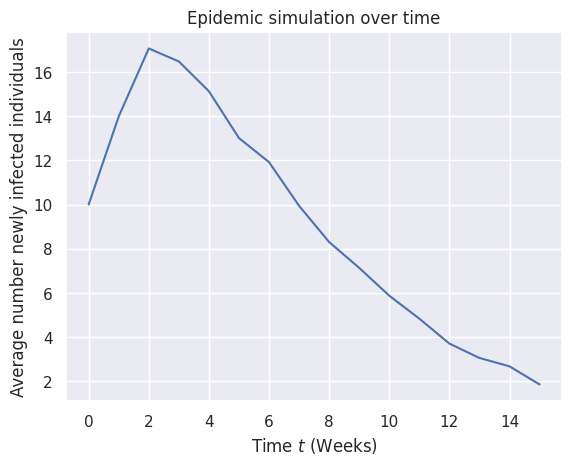

In [39]:
simplified_plot(average_new_nodes_infected,
                title="Epidemic simulation over time",
                xlabel='Time $t$ (Weeks)',
                ylabel='Average number newly infected individuals'
                )
plt.show()

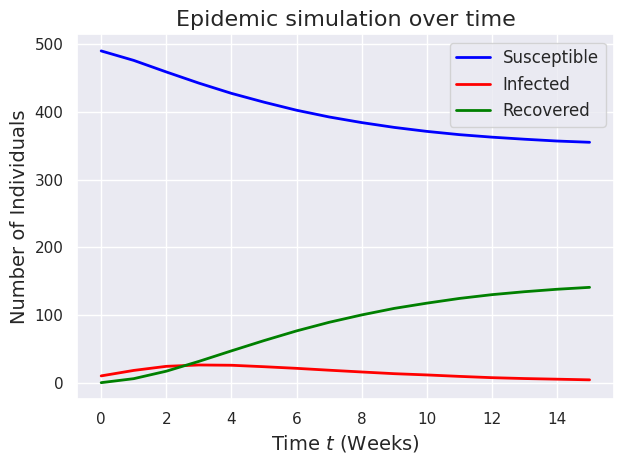

In [40]:
# Calculate the average states for S, I, R
average_states = calculate_average_states(S)

# Plotting the results

plt.plot(average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic simulation over time", fontsize=16)
plt.xlabel("Time $t$ (Weeks)", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

### 1.1.2 Generate a random graph
In this part you will generate a random graph according to the preferential attachment model. The goal is to have a randomly generated graph with average degree close to k. The idea is the following: at time t = 1 we start with an initial graph G1, that is complete with k +1 nodes. Then
at every time t >= 2, create a new graph $G_t$ = ($V_t$; $E_t$) by adding a new node to $G_{t-1}$ and connect it to some of the existing nodes $V_{t-1}$ of $G_{t-1}$ chosen according to some stochastic rule.

The rule by which the new node add links to the nodes of $G_{t-1}$ is preferential attachment. This means that at every time-step t >= 2, every new node added at time t will have a degree $w_t(t) = c = k/2$. Hence, it should add c undirected links to the existing graph $G_{t-1}$. It decides which of the nodes in $V_{t-1}$ it should connect to based on some probability that is proportional to the current degree of the node it is connecting to. In other words, if we denote the new node $n_t$, the probability that there will be a link between node $n_t$ and node i $\epsilon$ $V_{t-1}$ is:
<figure>
    <img width="700" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H3/sources/F2.png"/>
  
</figure>

where W(t) is the adjacency matrix for the next time-step t and $w_i(t-1)$ is the degree of node i prior to adding the new node. Some care should be taken here so that you do not add multiple links to the same node.

You should also note that if k is odd, it is a bit trickier to generate the random graph such that the average degree will be k. If k happens to be an odd number, then c = k/2 will not be an integer. However, it is still possible to achieve an average degree of k when you add a large number of nodes. This can be done by alternating between adding [k/2] and [k/2] links when adding a
new node to the graph.

**Problem 1.2:** Your goal is to, by using preferential attachment, generate a random graph of a large size (at least 900 nodes) with average degree k $\epsilon$ $Z^+$. Let the initial graph $G=\left(V_1, E_1\right)$ be
a complete graph with $|V_1| = k_0 = k + 1$ nodes.

Note that the goal here is to implement a fairly general algorithm where it is very easy to change the average degree. It should be possible to change the average degree by only changing the value of k in your algorithm. This algorithm will then be used in Section 1.4.

In [41]:
# Function to generate a preferential attachment graph
def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)
    add_edges = [k // 2, (k + 1) // 2]

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n):
        G.add_node( t-1) #t-1 to prevent a jump in node name enumeration n={4,5,6,___,8,9}

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Alternate edge count for odd k
        num_edges = add_edges[(t - (k + 2)) % 2] if k % 2 else k // 2  # Fix to add k/2 edges per new node

        # Loop to ensure no redundant edges to the same target
        while len(targets) < num_edges:
            # Probability of connecting to an existing node is proportional to its current degree wi(t-1)
            chosen = random.choices(
                population=list(degrees.keys()),
                weights=list(degrees.values()),
                k=1
            )[0]
            if chosen != (t - 1):  # Avoid self-loops
                targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)

    return G

In [42]:
n = 900
k = 6
G = preferential_attachment_graph(n, k)

# Check average degree
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Generated graph with average degree: {average_degree}")

Generated graph with average degree: 5.993333333333333


## 1.2 Simulate a pandemic without vaccination
In this part you will be using the graph generated in Section 1.1.2 and then simulate an epidemic on it. The disease propagation model is again the discrete-time version of the SIR epidemic model used in Section 1.1.1.


**Problem 2:** Using the methods developed in Section 1.1, generate a preferential attachment random graph $G=\left(V, E\right)$ with $\left|V\right|=500$ nodes. The average degree should be $k=6$. Let $\beta=0.25$ and $\rho=0.6$. With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at a random from the node set $V$, or make a different choice of initial configuration (In the latter case, please briefly discuss your motivation).

Do this $N=100$ times and plot the following:
* The average number of newly infected individuals each week. In other words, you should plot how many people *become* infected each week.
* The average total number of susceptible, infected, and recovered individuals at each week. In other words, you should plot how many individuals *in total are* susceptible/infected/recovered at each week.

In [43]:
# Parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = np.random.choice(range(n), 10)

In [44]:
# Generate graph
G = preferential_attachment_graph(n, k)

# Set initial configuration of the node state
color_map = []
for i in range(n):
    if i in initial_infected_nodes:
        G.nodes[i]['state'] = 'I'
        color_map.append('red')
    else:
        G.nodes[i]['state'] = 'S'
        color_map.append('lightblue')

# Run simulations
S = Simulations(G, beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)

average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Generated graph with average degree: {average_degree}")

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)

100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


Generated graph with average degree: 5.988


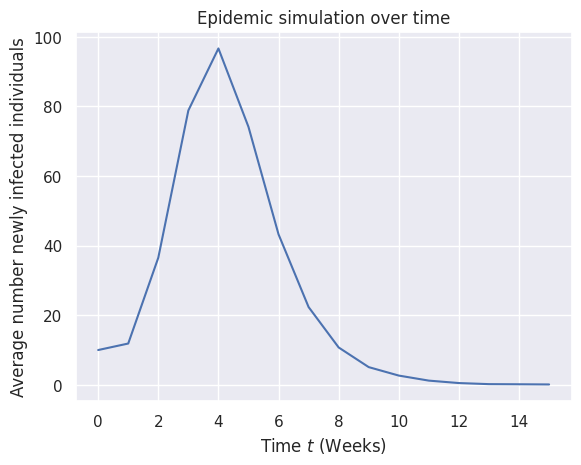

In [45]:
# Plotting average number of newly infected individuals each week.
simplified_plot(average_new_nodes_infected,
                title="Epidemic simulation over time",
                xlabel='Time $t$ (Weeks)',
                ylabel='Average number newly infected individuals'
                )
plt.show()

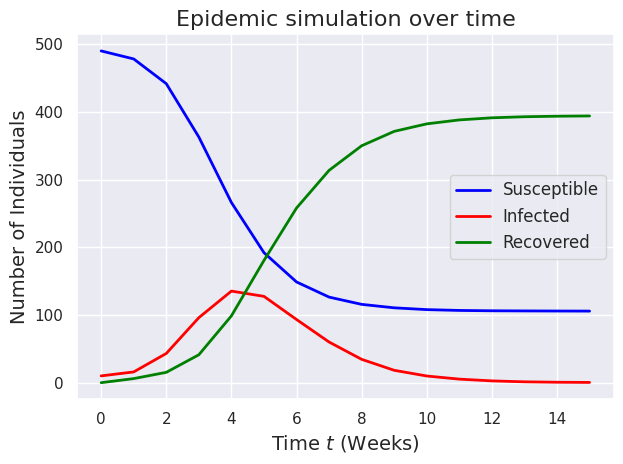

In [46]:
#Plotting average total number of susceptible, infected, and recovered individuals at each week
# Calculate the average states for S, I, R
average_states = calculate_average_states(S)

# Plotting the results

plt.plot(average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic simulation over time", fontsize=16)
plt.xlabel("Time $t$ (Weeks)", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

## 1.3 Simulate a pandemic with vaccination

In this part you will essentially do the same thing as before, but you will also try to take some action to slow down the epidemic. This is normally done using vaccination. Therefore, during each week, some parts of the population will receive vaccination. Once a person is vaccinated it cannot be infected. Furthermore, the vaccination is assumed to take effect immediately once given, i.e. if person a is vaccinated in week 10, then a is no longer susceptible during that week, and can therefore not infect any other individual.

You should once again simulate the disease propagation for 15 weeks, but you should now also distribute vaccination to the population. This should be done such that the total fraction of population that has received vaccination by each week is according to:

Vacc(t) = [0; 5; 15; 25; 35; 45; 55; 60; 60; 60; 60; 60; 60; 60; 60]:

Vacc(t) should be interpreted as: 55% of the population has received vaccination by week 7, and 5% received vaccination during week 7.

To simulate the actual vaccination you should, at the beginning of each week,find the correct number of individuals to vaccinate according to Vacc(t). You should then find individuals to vaccinate. These individuals should be selected uniformly at random from the population that has not yet received vaccination. This means that an infected individual might receive vaccination as well. The reason behind this is that some people were not able to tell whether they had the H1N1-virus or just the common cold. If an infected individual becomes vaccinated it is assumed that she will not be able to infect another individual. In other words, we assume that regardless of the state of an individual prior to the vaccination, once vaccinated the individual will not be able to become infected nor infect any other individuals.


**Problem 3:** Using the methods developed in Section, generate a random graph $G=\left(V, E\right)$ with $\left|V\right|=500$ nodes. The average degree should be $k=6$. Let $\beta=0.25$ and $\rho=0.6$. With one week being one unit of time, simulate the epidemic for 15 weeks. using the vaccination scheme Vacc(t) above.You can choose an initial configuration with 10 infected nodes selected at a random from the node set $V$, or make a different choice of initial configuration (In the latter case, please briefly discuss your motivation).

Do this $N=100$ times and plot the following:
* The average number of newly infected individuals each week. In other words, you should plot how many people *become* infected each week.
* The average total number of susceptible, infected, recovered and vaccinated individuals at each week.

In [47]:
# Getting the infected and not vaccinated neighbors of a node
def get_infected_neighbors(G, i):
    return list(filter(lambda neighbor: G.nodes[neighbor]['state'] == 'I' and G.nodes[neighbor]['vaccinated'] == 0, G.neighbors(i)))

def sample_individuals(size):
    numbers = list(range(500))
    random.shuffle(numbers) #random shuffle the list

    while numbers:  # while theres available numbers
        yield numbers[:size]  # return a sample
        del numbers[:size]  # delete the sampled numbers

# Setting a node as vaccinated
def vaccinate_individuals(G, k):
    sampled_nodes = next(sample_individuals(k))
    for node in sampled_nodes:
        G.nodes[node]['vaccinated'] = 1


In [48]:
def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    vacc_t = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60,60] #total
    # We do not want to modify the original graph
    G = G.copy()

    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))

    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))


    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)
        vacc_sample = (vacc_t[t]-vacc_t[t-1])*5 #percentage of people to vaccinate
        vaccinate_individuals(G_copy, vacc_sample)
        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            vaccinated = G_copy.nodes[i]['vaccinated']
            if new_state == 'S':
                # 1 if i got infected, 0 otherwise
                if not vaccinated:
                    i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))
                else:
                    i_is_infected = 0

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1
                elif vaccinated:
                    new_state = 'R'

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected


In [49]:
# Generate graph
G = preferential_attachment_graph(n, k)

# Set initial state for nodes
for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

for node in G.nodes():
    if node not in initial_infected_nodes:
        G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

# Run simulations
S = Simulations(G, beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)



100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


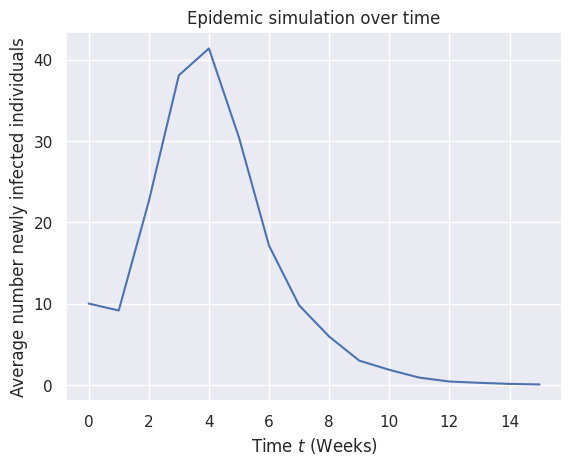

In [50]:
# Plotting average number of newly infected individuals each week.
simplified_plot(average_new_nodes_infected,
                title="Epidemic simulation over time",
                xlabel='Time $t$ (Weeks)',
                ylabel='Average number newly infected individuals'
                )
plt.show()

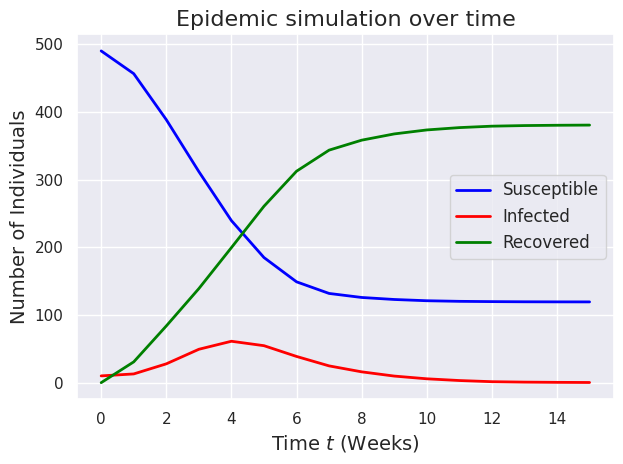

In [51]:
#Plotting average total number of susceptible, infected, and recovered individuals at each week
# Calculate the average states for S, I, R
average_states = calculate_average_states(S)

# Plotting the results

plt.plot(average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic simulation over time", fontsize=16)
plt.xlabel("Time $t$ (Weeks)", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

FALTA GRAFICAR EL NUMERO DE VACUNADOS